Inicialmente podemos ler o dataset e visualizar algumas propriedades e características dos dados.

Analisando o dataset, é possível ver que se trata de 150 plantas, onde cada planta possui 4 features, onde cada planta pode ser classificada como uma entre três possíveis especíes.

In [1]:
import pandas as pd

iris = pd.read_csv('Iris.csv')
print(iris.head(), "\n")
print(iris.info(), "\n")
print(iris.describe())


   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa 

<class 'pandas.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    str    
dtypes: float64(4), int64(1), str(1)
memory usage: 7.2 KB
None 

               Id  SepalLe

Inicialmente, como em qualquer projeto de ML é ideal começar separarando o dataset em dois conjuntos: um de treinamento e outro de teste. A proporção é de 20%.

In [2]:
from sklearn.model_selection import train_test_split

X_iris = iris.drop(["Id","Species"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X_iris, iris["Species"], train_size=0.8 ,random_state=42 
)

print(f"Shape do conjunto de treinamento -> X: {X_train.shape} | y: {y_train.shape}")
print(f"Shape do conjunto de teste -> X: {X_test.shape} | y: {y_test.shape}")

Shape do conjunto de treinamento -> X: (120, 4) | y: (120,)
Shape do conjunto de teste -> X: (30, 4) | y: (30,)


Nesta abordagem, o foco está principalmente em utilizar e visualizar como o método PCA funciona e em como o conjunto de features ($n=4$) pode ser reduzido ($n=2$). 

Primeiro precisamos encontrar a matriz de covariância. Para isso, é necessário primeiro padronizar o dataset de treinamento. 

Obs: Você pode optar por usar o `StandardScaler` da `Scikit-Learn` ou implementar a padronização na mão.
Para implementar na mão, é só aplicar a fórmula: 

$$
Z = \frac{X_{ij} - \mu_j}{\sigma_j}

$$

onde $X_{ij}$ é o valor, $\mu_j$ é a média da feature $j$ e $\sigma_j$ é o desvio padrão da feature $j$.

In [3]:
X_train_scaled = (X_train - X_train.mean()) / X_train.std() 
X_test_scaled = (X_test - X_train.mean()) / X_train.std()

print(X_train_scaled.head())

    SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
22      -1.467783      1.215284      -1.557457     -1.304016
15      -0.132515      3.007407      -1.271947     -1.038567
65       1.081364      0.095207       0.384011      0.288675
11      -1.225007      0.767253      -1.214845     -1.304016
42      -1.710558      0.319222      -1.386151     -1.304016


Agora com o dataset de treinamento padronizado, podemos encontrar a matriz de covariância através da fórmula: 

$$\Sigma = \frac{1}{n-1} Z^T Z
$$

(novamente você pode preferir por usar as funções prontas da Scikit-Learn).

In [4]:
import numpy as np 

matrix_covariance = (1 / (len(X_train)-1)) * np.dot(X_train_scaled.T, X_train_scaled)
print(matrix_covariance)

[[ 1.         -0.09719131  0.86218318  0.80148454]
 [-0.09719131  1.         -0.42244683 -0.35776809]
 [ 0.86218318 -0.42244683  1.          0.96243225]
 [ 0.80148454 -0.35776809  0.96243225  1.        ]]


Através da decomposição espectral $\Sigma v = \lambda v$, precisamos encontrar os autovalores e autovetores da matriz de covariância encontrada acima. Importante que eles estejam ordenados em ordem decrescente (do maior para o menor).



In [5]:
eigenvalues, eigenvectors = np.linalg.eigh(matrix_covariance)
sorted_index = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_index]
eigenvectors = eigenvectors[:, sorted_index]

print(f"Autovalores: {eigenvalues}\n")
print(f"Autovetores: \n{eigenvectors}")

Autovalores: [2.8927075  0.9286106  0.15933859 0.01934331]

Autovetores: 
[[-0.51906552  0.38466253  0.71689541  0.26204332]
 [ 0.26388962  0.92103961 -0.25660271 -0.12729237]
 [-0.58330585  0.01771616 -0.13942607 -0.8000005 ]
 [-0.5662928   0.05836874 -0.63306903  0.52452756]]


Fazendo uma pequena tangente...

Eu citei que o objetivo principal deste projeto era fazer o PCA de 4D para 2D, mas por quê? Bom, usamos a padronização z-score que nos força para cada uma das 4 feature (`SepalLength`, etc.) a ter uma média 0 e uma variância 1. Logo, a variância total (como desmonstrada abaixo) deve ser igual a 4, somando todos os autovalores. Na prática, o PCA não cria nem destrói informação, ele apenas a redistribui. Em vez de ter a variância espalhada igualmente (1, 1, 1, 1), ela é reorganizada para algo como (2,9, 0.9, 0.16, 0.20) entre os autovalores. 

Existe então uma taxa de variância explicada, que é a relação entre um autovalor e a soma total dos autovalores (variância total). Imagine que temos um bolo e cortamos ele em 4 pedaços. A taxa de variância explicada é como perguntar: "De todo o bolo (em 4 pedaços), quanto um pedaço (e.g., $\lambda_1$) representa do bolo?". No nosso problema, o pedaço $\lambda_1$ representa aproximadamente 72% do bolo, o que é significa que é um baita pedaço. 

Ao considerar os dois pedaços do bolo (os dois maiores autovetores) temos 95% da representação total do bolo. Os 5% restantes distribuidos nos outros dois pedaços são praticamente insignificantes (neste caso).

In [6]:
total_variance = sum(eigenvalues)
print(f"Variância total: {total_variance}")

print("\nTaxa de variância explicada:")
pc_variance = [(i / total_variance) * 100 for i in eigenvalues]
for variance, cont in zip(pc_variance, [1,2,3,4]):
    print(f"Variância PC{cont}: {variance:.2f}%")
    
print(f"Variância para 2D (PC1 + PC2): {sum(pc_variance[:2]):.2f}")


Variância total: 4.000000000000003

Taxa de variância explicada:
Variância PC1: 72.32%
Variância PC2: 23.22%
Variância PC3: 3.98%
Variância PC4: 0.48%
Variância para 2D (PC1 + PC2): 95.53


Agora precisamos criar uma matriz reduzida $W$ contendo as $k$ colunas que queremos da matriz de autovetores ordenada. Para este problema, vamos usar $k=2$.

Em seguida, precisamos encontrar a matriz pca $X_{\text{pca}} = X_{\text{scaled}} \dot W$ que é resultante do produto escalar entre a nossa matriz padronizada e a nova matriz reduzida.

In [7]:
W = eigenvectors[:, 0:2]
print(f"Matriz reduzida: \n{W}\n")

X_train_pca = np.dot(X_train_scaled, W)
print(f"Matriz PCA {X_train_pca.shape}: \n{X_train_pca[:5]}")

X_test_pca = np.dot(X_test_scaled, W)

Matriz reduzida: 
[[-0.51906552  0.38466253]
 [ 0.26388962  0.92103961]
 [-0.58330585  0.01771616]
 [-0.5662928   0.05836874]]

Matriz PCA (120, 2): 
[[ 2.72950469  0.45101758]
 [ 2.19247498  2.63581365]
 [-0.92364544  0.52730213]
 [ 2.28540983  0.13781996]
 [ 2.5191361  -0.46464267]]


Agora como temos uma matriz de duas dimensões, podemos plotar o gráfico e visualizar como essas componentes principais se comportam.

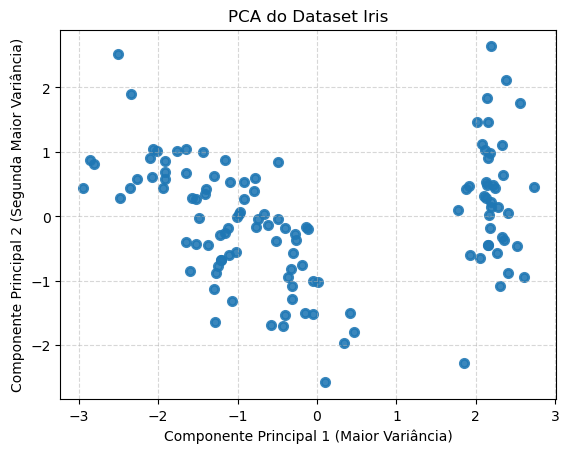

In [8]:
import matplotlib.pyplot as plt 

plt.scatter(X_train_pca[:,0], X_train_pca[:,1], alpha=0.88, lw=2)
plt.title('PCA do Dataset Iris')
plt.xlabel('Componente Principal 1 (Maior Variância)')
plt.ylabel('Componente Principal 2 (Segunda Maior Variância)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Esse gráfico acima não diz muito. Podemos melhor e vamos! Considere agora o gráfico abaixo, ele está usando a verdadeira espécie para cada uma das plantas. Note como fica bem mais fácil de separar e classificar cada especíe com base nas duas features abaixo.  

Podemos ver que a espécie Setosa é perfeitamente separável das outras apenas com o primeiro componente principal, enquanto Versicolor e Virginica ainda possuem uma leve sobreposição.

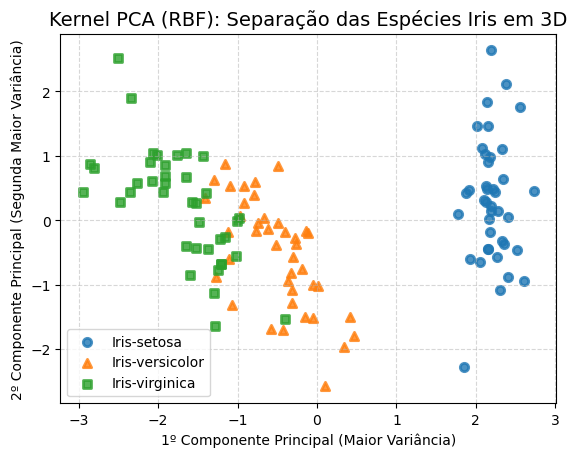

In [9]:
species = np.unique(y_train)
markers = ['o', '^', 's'] 

for specie, marker in zip(species, markers):
      mask = (y_train == specie)
      
      plt.scatter(
          X_train_pca[mask, 0],
          X_train_pca[mask, 1],
          alpha=0.8,
          lw=2,
          marker=marker,
          label=specie
      )
      
plt.legend(loc='best')
plt.title("Kernel PCA (RBF): Separação das Espécies Iris em 3D", fontsize=14)
plt.xlabel("1º Componente Principal (Maior Variância)")
plt.ylabel("2º Componente Principal (Segunda Maior Variância)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Vamos usar um algoritmo de K-NN com $k=5$ para este problema e verificar a precisão do modelo.

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

k = 5
knn_pca = KNeighborsClassifier(n_neighbors=k)

knn_pca.fit(X_train_pca, y_train)
y_pred_kpca = knn_pca.predict(X_test_pca)

print(f"Acurácia global do PCA usando K-NN: {accuracy_score(y_test, y_pred_kpca)}")

Acurácia global do PCA usando K-NN: 0.9333333333333333


Ok, as coisas melhoraram. Aplicamos algum algoritmo de classificação (K-NN) diretamente, porém, podemos fazer tentar outras transformações nas nossas features.

Podemos substituir a PCA Linear que fizemos pela Kernel PCA. O que estamos fazendo é usando um algoritmo (o Kernel's trick) para transformar os nossos dados de dimensão 4D para 3D. O motivo disso é que ao visualizar o gráfico 2D gerado pelo PCA, encontrar uma distinção entre as espécies verisolor e vírginica possa ser dificíl para o algoritmo. Talvez usando uma dimensão maior 3D, fica mais claro a separação.  

Podemos construir uma dimensão $z$ a partir da nossas duas dimensões do PCA, e.g., $z=(c + d)^2? Em geral, não. Se tentassemos reconstruir uma estrutura complexa (3D) a partir de uma "sombra" achatada (2D, obtida a partir do PCA), a informação "rica" sobre a curvatura dos dados já seria perdida no primeiro passo. Uma vez que aplicamos a PCA para projetar os dados, a estrutura original é perdida.

Portanto, o fluxo correto da troca do PCA pelo Kernel é dado a seguir:
* Antigo: Original (4D) -> PCA (2D) -> kPCA (3D) (Perda de informação)
* Atual: Original (4D) -> kPCA (3D) (Captura bem as informações "direto da fonte") 

In [11]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=3, kernel='rbf', gamma=0.1)

X_train_kpca = kpca.fit_transform(X_train_scaled)
print(X_train_kpca[:5])

X_test_kpca = kpca.transform(X_test_scaled)

[[ 0.75846375 -0.17742242  0.02941933]
 [ 0.50628983 -0.42319267 -0.32751775]
 [-0.35371383 -0.14863691 -0.12183048]
 [ 0.71907919 -0.0594525   0.04620509]
 [ 0.70351166  0.04275399  0.26890331]]


Note como agora é possível (com um certo esforço) separar cada espécie por um "bowl". 

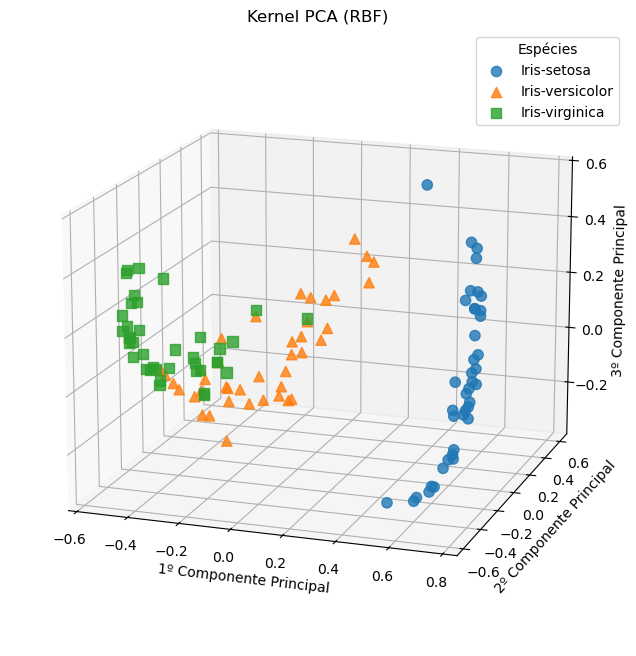

In [12]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, specie, marker in zip([0, 1, 2], species, markers):
    mask = (y_train == specie)
    
    ax.scatter(
        X_train_kpca[mask, 0],  
        X_train_kpca[mask, 1],  
        X_train_kpca[mask, 2],  
        alpha=0.8,       
        s = 55,
        marker=marker,
        label=specie
    )

ax.set_title("Kernel PCA (RBF)")
ax.set_xlabel("1º Componente Principal")
ax.set_ylabel("2º Componente Principal")
ax.set_zlabel("3º Componente Principal")
ax.legend(loc="best", title="Espécies")
ax.view_init(elev=16, azim=289)
plt.show()

O que nos resta é por em prática os dois datasets `X_train_pca` (2D) e `X_train_kpca` (3D) para treinar e ver qual possui uma melhor taxa de acertos. Vamos usar o algoritmo de K-NN e verificar a diferença da taxa de acertos entre os dois datasets.

In [13]:
knn_kpca = KNeighborsClassifier(n_neighbors=k)

knn_kpca.fit(X_train_kpca, y_train)
y_pred_kpca = knn_kpca.predict(X_test_kpca)

print(f"Acurácia global do KPCA: {accuracy_score(y_test, y_pred_kpca)}")


Acurácia global do KPCA: 0.9333333333333333


No final das contas, não houveram mudanças no final, portanto o PCA de (2D) é preferível. 

Como o Iris possui fronteiras de decisão lineares, o PCA padrão já oferece excelente performance, mas o KPCA foi implementado para fins de demonstração